# Modeling - ethereum - v5 - Comparação

# Setup

## Library import
We import all the required Python libraries

In [63]:
import os
import time

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import (
    LGBMClassifier, plot_importance, create_tree_digraph, plot_tree
)
import missingno as msno
# from pycaret.classification import ClassificationExperiment
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, cross_validate, KFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
from sklearn import set_config

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
set_config(transform_output = "pandas")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=2, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Local library import
We import all the required local libraries libraries

In [64]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

def round_4(x):
    return x.round(4)

def save_dict_to_txt(content: dict, file_path: str, mode: str = 'w', encoding: str = 'utf-8') -> None:
    try:
        with open(file_path, mode=mode, encoding=encoding) as f:
            for key, value in content.items():
                f.write(f"{key}: {value}\n")
        print(f"Dictionary successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving file: {str(e)}")

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [65]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42

GENERATE_REPORTS = True

dct_active_models = {
    'lightgbm': True,
    'random_forest': True,
    'decision_tree': True,
    'knn': True,
    'catboost': True,
    'xgboost': True,
}

train_size = 0.15
scoring_metric = ['roc_auc', 'f1', 'recall']
refit_metric = 'roc_auc'


# palette = sns.color_palette("Spectral", as_cmap=True)
palette = sns.color_palette("husl", 10)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379026, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.9622723935096688, 0.3976451968965351, 0.8008274363432775)]

# Experience 01 - Only numerical attributes

## Data import

In [66]:
df_train_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_train_exp_01.pqt')
df_test_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_test_exp_01.pqt')

display(df_train_exp_01.head(3))

Address  FLAG  Avg_min_between_sent_tnx  \
1  0x0002b44ddb1476db43c868bd494422ee4c136fed     0               12709.07000   
2  0x0002bda54cb772d040f779e88eb453cac0daa244     0              246194.54000   
4  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0                  36.61000   

   Avg_min_between_received_tnx  Time_Diff_between_first_and_last_(Mins)  \
1                    2958.44000                            1218216.73000   
2                    2434.02000                             516729.30000   
4                   10707.77000                             382472.42000   

   Sent_tnx  Received_Tnx  Number_of_Created_Contracts  \
1        94             8                            0   
2         2            10                            0   
4      4598            20                            1   

   Unique_Received_From_Addresses  Unique_Sent_To_Addresses  \
1                               5                        14   
2                              10                         2   
4                               7                        19   

   min_value_received  max_value_received  avg_val_received  min_val_sent  \
1             0.00000             2.61327           0.38569       0.00000   
2             0.11312             1.16545           0.35891       0.05000   
4             0.00000            12.80241           2.67110       0.00000   

   max_val_sent  avg_val_sent  min_value_sent_to_contract  \
1       1.80000       0.03284                     0.00000   
2       3.53862       1.79431                     0.00000   
4       9.00000       0.02269                     0.00000   

   max_val_sent_to_contract  avg_value_sent_to_contract  \
1                   0.00000                     0.00000   
2                   0.00000                     0.00000   
4                   0.00000                     0.00000   

   total_transactions_(including_tnx_to_create_contract  total_Ether_sent  \
1                                                   102           3.08730   
2                                                    12           3.58862   
4                                                  4619         104.31888   

   total_ether_received  total_ether_sent_contracts  total_ether_balance  \
1               3.08548                     0.00000             -0.00182   
2               3.58906                     0.00000              0.00044   
4              53.42190                     0.00000            -50.89699   

   Total_ERC20_tnxs  ERC20_total_Ether_received  ERC20_total_ether_sent  \
1           8.00000                   403.42831                 2.26081   
2           8.00000                   521.51207                 0.00000   
4          42.00000                162829.66090            123539.93290   

   ERC20_total_Ether_sent_contract  ERC20_uniq_sent_addr  ERC20_uniq_rec_addr  \
1                          0.00000               1.00000              5.00000   
2                          0.00000               0.00000              7.00000   
4                          0.00000               4.00000             23.00000   

   ERC20_uniq_sent_addr.1  ERC20_uniq_rec_contract_addr  ERC20_min_val_rec  \
1                 0.00000                       7.00000            0.00000   
2                 0.00000                       8.00000            0.00000   
4                 0.00000                      27.00000            0.00000   

   ERC20_max_val_rec  ERC20_avg_val_rec  ERC20_min_val_sent  \
1          365.00000           57.63262             2.26081   
2          442.81984           65.18901             0.00000   
4        90000.00000         4934.23215             0.00000   

   ERC20_max_val_sent  ERC20_avg_val_sent  ERC20_uniq_sent_token_name  \
1             2.26081             2.26081                     1.00000   
2             0.00000             0.00000                     0.00000   
4         45000.00000         13726.65922                     6.00000   

   ERC20_uniq_rec_token_name  
1

# Categorical features encoded by frequency

## Data import

In [67]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'transaction_dataset.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

print(f"""
X_train_exp_02: {X_train_exp_02.shape}
y_train_exp_02: {y_train_exp_02.shape}

X_test_exp_02: {X_test_exp_02.shape}
y_test_exp_02: {y_test_exp_02.shape}
""")

display(X_train_exp_02.head(3))


X_train_exp_02: (8343, 40)
y_train_exp_02: (8343, 1)

X_test_exp_02: (1473, 40)
y_test_exp_02: (1473, 1)



Avg_min_between_sent_tnx  Avg_min_between_received_tnx  \
2859                 163.07000                       0.17000   
2149                   0.00000                       4.64000   
2979                1050.50000                     887.86000   

      Time_Diff_between_first_and_last_(Mins)  Sent_tnx  Received_Tnx  \
2859                                326.47000         2             2   
2149                               2726.18000         1             2   
2979                            1393223.92000       689           754   

      Number_of_Created_Contracts  Unique_Received_From_Addresses  \
2859                            0                               2   
2149                            0                               1   
2979                            0                             405   

      Unique_Sent_To_Addresses  min_value_received  max_value_received  \
2859                         2            35.49665            65.50334   
2149                         1             0.01500             6.90985   
2979                       448             0.00000            81.82880   

      avg_val_received  min_val_sent  max_val_sent  avg_val_sent  \
2859          50.50000       3.00000      97.99902      50.49951   
2149           3.46242       6.92436       6.92436       6.92436   
2979           1.66417       0.00000      59.98000       1.52056   

      min_value_sent_to_contract  max_val_sent_to_contract  \
2859                     0.00000                   0.00000   
2149                     0.00000                   0.00000   
2979                     0.00000                   0.00000   

      avg_value_sent_to_contract  \
2859                     0.00000   
2149                     0.00000   
2979                     0.00000   

      total_transactions_(including_tnx_to_create_contract  total_Ether_sent  \
2859                                                     4         100.99902   
2149                                                     3           6.92436   
2979                                                  1443        1047.66474   

      total_ether_received  total_ether_sent_contracts  total_ether_balance  \
2859             101.00000                     0.00000              0.00098   
2149               6.92485                     0.00000              0.00049   
2979            1254.78214                     0.00000            207.11740   

      Total_ERC20_tnxs  ERC20_total_Ether_received  ERC20_total_ether_sent  \
2859           0.00000                     0.00000                 0.00000   
2149           0.00000                     0.00000                 0.00000   
2979          31.00000               2547558.02500               387.73596   

      ERC20_total_Ether_sent_contract  ERC20_uniq_sent_addr  \
2859                          0.00000               0.00000   
2149                          0.00000               0.00000   
2979                          0.00000               1.00000   

      ERC20_uniq_rec_addr  ERC20_uniq_sent_addr.1  \
2859              0.00000                 0.00000   
2149              0.00000                 0.00000   
2979             19.00000                 0.00000   

      ERC20_uniq_rec_contract_addr  ERC20_min_val_rec  ERC20_max_val_rec  \
2859                       0.00000            0.00000            0.00000   
2149                       0.00000            0.00000            0.00000   
2979                      23.00000            0.00000      2537935.00000   

      ERC20_avg_val_rec  ERC20_min_val_sent  ERC20_max_val_sent  \
2859            0.00000             0.00000             0.00000   
2149            0.00000             0.00000             0.00000   
2979        87846.82844             0.70000           387.03596   

      ERC20_avg_val_sent  ERC20_uniq_sent_token_name  \
2859             0.00000                     0.00000   
2149             0.00000                     0.00000   
2979           193.86798                     1.00000   


In [68]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'transaction_dataset.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'artigo_df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

print(f"""
X_train_exp_02: {X_train_exp_02.shape}
y_train_exp_02: {y_train_exp_02.shape}

X_test_exp_02: {X_test_exp_02.shape}
y_test_exp_02: {y_test_exp_02.shape}
""")

display(X_train_exp_02.head(3))


X_train_exp_02: (8343, 40)
y_train_exp_02: (8343, 1)

X_test_exp_02: (1473, 40)
y_test_exp_02: (1473, 1)



Avg_min_between_sent_tnx  Avg_min_between_received_tnx  \
2859                 163.07000                       0.17000   
2149                   0.00000                       4.64000   
2979                1050.50000                     887.86000   

      Time_Diff_between_first_and_last_(Mins)  Sent_tnx  Received_Tnx  \
2859                                326.47000         2             2   
2149                               2726.18000         1             2   
2979                            1393223.92000       689           754   

      Number_of_Created_Contracts  Unique_Received_From_Addresses  \
2859                            0                               2   
2149                            0                               1   
2979                            0                             405   

      Unique_Sent_To_Addresses  min_value_received  max_value_received  \
2859                         2            35.49665            65.50334   
2149                         1             0.01500             6.90985   
2979                       448             0.00000            81.82880   

      avg_val_received  min_val_sent  max_val_sent  avg_val_sent  \
2859          50.50000       3.00000      97.99902      50.49951   
2149           3.46242       6.92436       6.92436       6.92436   
2979           1.66417       0.00000      59.98000       1.52056   

      min_value_sent_to_contract  max_val_sent_to_contract  \
2859                     0.00000                   0.00000   
2149                     0.00000                   0.00000   
2979                     0.00000                   0.00000   

      avg_value_sent_to_contract  \
2859                     0.00000   
2149                     0.00000   
2979                     0.00000   

      total_transactions_(including_tnx_to_create_contract  total_Ether_sent  \
2859                                                     4         100.99902   
2149                                                     3           6.92436   
2979                                                  1443        1047.66474   

      total_ether_received  total_ether_sent_contracts  total_ether_balance  \
2859             101.00000                     0.00000              0.00098   
2149               6.92485                     0.00000              0.00049   
2979            1254.78214                     0.00000            207.11740   

      Total_ERC20_tnxs  ERC20_total_Ether_received  ERC20_total_ether_sent  \
2859           0.00000                     0.00000                 0.00000   
2149           0.00000                     0.00000                 0.00000   
2979          31.00000               2547558.02500               387.73596   

      ERC20_total_Ether_sent_contract  ERC20_uniq_sent_addr  \
2859                          0.00000               0.00000   
2149                          0.00000               0.00000   
2979                          0.00000               1.00000   

      ERC20_uniq_rec_addr  ERC20_uniq_sent_addr.1  \
2859              0.00000                 0.00000   
2149              0.00000                 0.00000   
2979             19.00000                 0.00000   

      ERC20_uniq_rec_contract_addr  ERC20_min_val_rec  ERC20_max_val_rec  \
2859                       0.00000            0.00000            0.00000   
2149                       0.00000            0.00000            0.00000   
2979                      23.00000            0.00000      2537935.00000   

      ERC20_avg_val_rec  ERC20_min_val_sent  ERC20_max_val_sent  \
2859            0.00000             0.00000             0.00000   
2149            0.00000             0.00000             0.00000   
2979        87846.82844             0.70000           387.03596   

      ERC20_avg_val_sent  ERC20_uniq_sent_token_name  \
2859             0.00000                     0.00000   
2149             0.00000                     0.00000   
2979           193.86798                     1.00000   


## Configurando modelos e dicionários de modelos

In [69]:
max_depth = np.arange(3, 36, 5).tolist(),
num_leaves = np.arange(2**np.min(max_depth), 70, 5).tolist()

lightgbm = LGBMClassifier(boosting_type='gbdt', random_state=RANDOM_STATE, n_jobs=-1, objective='binary', importance_type='split', verbosity=-1)
catboost = CatBoostClassifier( random_state=RANDOM_STATE, verbose=0, early_stopping_rounds=20)
xgboost = XGBClassifier(
    random_state=RANDOM_STATE, objective='binary:logistic', eval_metric='logloss', early_stopping_rounds=10, n_jobs=-1, verbose_eval=None
)
random_forest = RandomForestClassifier(
    max_features='sqrt', bootstrap=True, n_jobs=-1, random_state=RANDOM_STATE, verbose=0
)
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
knn = KNeighborsClassifier(n_jobs=-1)

dct_models = {
    'lightgbm': {
        'model': lightgbm,
        'is_active': dct_active_models['lightgbm'],
        'dct_params': dict(
            max_depth = [3, 8, 13, 18, 23, 28, 33],
            num_leaves = [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68],
            learning_rate = [0.0001, 0.001, 0.01, 0.1],
            n_estimators = np.arange(50, 600, 100).tolist(),
        )
    },
    'random_forest': {
        'model': random_forest,
        'is_active': dct_active_models['random_forest'],
        'dct_params': dict(
            max_depth = [3, 8, 13, 18, 23, 28, 33],
            max_leaf_nodes = [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68],
            n_estimators = np.arange(50, 600, 100).tolist(),
        )
    },
    'decision_tree': {
        'model': decision_tree,
        'is_active': dct_active_models['decision_tree'],
        'dct_params': dict(
            max_depth = [3, 8, 13, 18, 23, 28, 33],
            max_leaf_nodes = [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68]
        )
    },
    'knn': {
        'model': knn,
        'is_active': dct_active_models['knn'],
        'dct_params': dict(
            n_neighbors = [3, 8, 13, 18, 23, 28, 33]
        )
    },
    'catboost': {
        'model': catboost,
        'is_active': dct_active_models['catboost'],
        'dct_params': dict(
            depth = [4, 6, 8, 10],
            learning_rate = [0.001, 0.01, 0.1],
            iterations = [100, 200, 300],
            l2_leaf_reg = [1, 3, 5],
            border_count = [32, 64, 128],
            random_strength = [0.1, 1, 10]
        )
    },
    'xgboost': {
        'model': xgboost,
        'is_active': dct_active_models['xgboost'],
        'dct_params': dict(
            max_depth = np.arange(3, 16, 4).tolist(),
            learning_rate = [0.0001, 0.001, 0.01, 0.1],
            n_estimators = np.arange(50, 600, 100).tolist(),
            reg_lambda = [0.1, 1, 3, 5, 10]
        )
    },
}

for key, item in dct_models.items():
    combinations = 1
    for param, values in item['dct_params'].items():
        combinations *= len(values)
    dct_models[key].update({'combinations': combinations})
    print(f"""{key}:
    dct_params: {item['dct_params']},
    combinations: {combinations}
    \n""")
    print(30*'-')

if GENERATE_REPORTS:
    save_dict_to_txt(content=dct_models, file_path=REPORTS_FOLDER+f'random_search-params_combinations-{scoring_metric}.txt')
else:
    print(f'GENERATE_REPORTS: {GENERATE_REPORTS}')


lightgbm:
    dct_params: {'max_depth': [3, 8, 13, 18, 23, 28, 33], 'num_leaves': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68], 'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'n_estimators': [50, 150, 250, 350, 450, 550]},
    combinations: 2184
    

------------------------------
random_forest:
    dct_params: {'max_depth': [3, 8, 13, 18, 23, 28, 33], 'max_leaf_nodes': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68], 'n_estimators': [50, 150, 250, 350, 450, 550]},
    combinations: 546
    

------------------------------
decision_tree:
    dct_params: {'max_depth': [3, 8, 13, 18, 23, 28, 33], 'max_leaf_nodes': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68]},
    combinations: 91
    

------------------------------
knn:
    dct_params: {'n_neighbors': [3, 8, 13, 18, 23, 28, 33]},
    combinations: 7
    

------------------------------
catboost:
    dct_params: {'depth': [4, 6, 8, 10], 'learning_rate': [0.001, 0.01, 0.1], 'iterations': [100, 200, 300], 'l2_leaf_reg': [

## Random search

In [70]:
dct_hyperparams = {}

for model in dct_models.keys():
    if dct_models[model]['is_active']:
        try:
            print(f'Iniciar {model}.')
            start_time = time.time()
            dct_params = dct_models[model]['dct_params']
            classifier = dct_models[model]['model']

            rscv = RandomizedSearchCV(
                classifier, dct_params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
                return_train_score=True, scoring=scoring_metric, cv=3, verbose=False, refit=refit_metric
            )

            if model == 'xgboost':
                search = rscv.fit(X_train_exp_02, y_train_exp_02['FLAG'].values, eval_set=[(X_test_exp_02, y_test_exp_02)])
            else:
                search = rscv.fit(X_train_exp_02, y_train_exp_02['FLAG'])

            dct_hyperparams[model] = {
                'best_rscv': search.best_params_,
                'results': rscv.cv_results_
                }
            end_time = time.time()
            execution_time = end_time - start_time
            print(f'O modelo {model} passou pela busca aleatória em {int(execution_time//60)} minutos e {execution_time%60:.1f} segundos.\n')
        except:
            print(f'Erro ao executar o modelo {model}.\n')

    else:
        print(f'O modelo {model} está desativado.\n')


Iniciar lightgbm.
O modelo lightgbm passou pela busca aleatória em 2 minutos e 45.4 segundos.

Iniciar random_forest.
O modelo random_forest passou pela busca aleatória em 4 minutos e 35.6 segundos.

Iniciar decision_tree.


c:\PROJETOS NO GIT\Tsu\ethereum_laundering\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning:

The total space of parameters 91 is smaller than n_iter=100. Running 91 iterations. For exhaustive searches, use GridSearchCV.



O modelo decision_tree passou pela busca aleatória em 0 minutos e 20.0 segundos.

Iniciar knn.


c:\PROJETOS NO GIT\Tsu\ethereum_laundering\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning:

The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.



O modelo knn passou pela busca aleatória em 0 minutos e 12.3 segundos.

Iniciar catboost.
O modelo catboost passou pela busca aleatória em 8 minutos e 13.4 segundos.

Iniciar xgboost.
[0]	validation_0-logloss:0.53020
[1]	validation_0-logloss:0.53012
[2]	validation_0-logloss:0.53004
[3]	validation_0-logloss:0.52996
[4]	validation_0-logloss:0.52988
[5]	validation_0-logloss:0.52980
[6]	validation_0-logloss:0.52972
[7]	validation_0-logloss:0.52964
[8]	validation_0-logloss:0.52956
[9]	validation_0-logloss:0.52948
[10]	validation_0-logloss:0.52940
[11]	validation_0-logloss:0.52932
[12]	validation_0-logloss:0.52924
[13]	validation_0-logloss:0.52916
[14]	validation_0-logloss:0.52909
[15]	validation_0-logloss:0.52901
[16]	validation_0-logloss:0.52893
[17]	validation_0-logloss:0.52885
[18]	validation_0-logloss:0.52877
[19]	validation_0-logloss:0.52869
[20]	validation_0-logloss:0.52861
[21]	validation_0-logloss:0.52853
[22]	validation_0-logloss:0.52845
[23]	validation_0-logloss:0.52838
[24]	valid

In [71]:
df_search_results = pd.DataFrame()

for model in dct_hyperparams.keys():
    print(model)
    df_random_search_results = pd.DataFrame.from_dict(dct_hyperparams[model]['results'], orient='columns')

    df_random_search_results.insert(0, 'model', model)

    df_search_results = pd.concat([df_search_results, df_random_search_results], axis=0, ignore_index=True)

df_search_results.sort_values(by=['model', 'rank_test_roc_auc'], inplace=True, ascending=True)
display(df_search_results.loc[df_search_results['rank_test_roc_auc'] <= 3])

if GENERATE_REPORTS:
    df_search_results.to_excel(REPORTS_FOLDER + f'artigo_random_search-{scoring_metric}.xlsx')
else:
    print(f'GENERATE_REPORTS: {GENERATE_REPORTS}')

lightgbm
random_forest
decision_tree
knn
catboost
xgboost


model  mean_fit_time  std_fit_time  mean_score_time  \
380       catboost        1.57140       0.03331          0.01315   
307       catboost        2.48568       0.13965          0.01213   
354       catboost        1.69550       0.06785          0.01597   
217  decision_tree        0.05188       0.00490          0.00922   
229  decision_tree        0.04933       0.00410          0.00862   
242  decision_tree        0.04858       0.00626          0.00936   
255  decision_tree        0.05147       0.00675          0.01024   
268  decision_tree        0.04896       0.00627          0.00852   
281  decision_tree        0.05101       0.00819          0.00957   
297            knn        0.00403       0.00040          0.25065   
295            knn        0.00456       0.00074          0.21401   
296            knn        0.00369       0.00022          0.22131   
33        lightgbm        0.24729       0.00422          0.03019   
92        lightgbm        0.33336       0.02988          0.03395   
24        lightgbm        0.26577       0.02994          0.02775   
126  random_forest        0.78711       0.02429          0.14330   
124  random_forest        0.97588       0.00381          0.17187   
187  random_forest        1.39154       0.13491          0.21865   
491        xgboost        2.51831       0.23953          0.10743   
405        xgboost        1.37304       0.18109          0.01980   
430        xgboost        1.92503       0.98516          0.02330   

     std_score_time  param_num_leaves  param_n_estimators  param_max_depth  \
380         0.00227               NaN                 NaN              NaN   
307         0.00074               NaN                 NaN              NaN   
354         0.00294               NaN                 NaN              NaN   
217         0.00051               NaN                 NaN          8.00000   
229         0.00013               NaN                 NaN         13.00000   
242         0.00185               NaN                 NaN         18.00000   
255         0.00200               NaN                 NaN         23.00000   
268         0.00052               NaN                 NaN         28.00000   
281         0.00118               NaN                 NaN         33.00000   
297         0.04869               NaN                 NaN              NaN   
295         0.00790               NaN                 NaN              NaN   
296         0.01827               NaN                 NaN              NaN   
33          0.00464          18.00000           250.00000         23.00000   
92          0.00466          23.00000           250.00000         18.00000   
24          0.00463          43.00000           150.00000          8.00000   
126         0.02842               NaN           350.00000         28.00000   
124         0.00832               NaN           450.00000         18.00000   
187         0.00804               NaN           550.00000         18.00000   
491         0.04857               NaN           350.00000          7.00000   
405         0.00138               NaN           350.00000          3.00000   
430         0.00421               NaN           450.00000          3.00000   

     param_learning_rate  \
380              0.10000   
307              0.10000   
354              0.10000   
217                  NaN   
229                  NaN   
242                  NaN   
255                  NaN   
268                  NaN   
281                  NaN   
297                  NaN   
295                  NaN   
296                  NaN   
33               0.10000   
92               0.10000   
24               0.10000   
126                  NaN   
124                  NaN   
187                  NaN   
491              0.10000   
405              0.10000   
430              0.10000   

                                                                                                                 params  \
380  {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_

## Grid search

In [72]:
for key, item in dct_hyperparams.items():
    print(f"{key}: {item['best_rscv']}")
    print()

lightgbm: {'num_leaves': 18, 'n_estimators': 250, 'max_depth': 23, 'learning_rate': 0.1}

random_forest: {'n_estimators': 350, 'max_leaf_nodes': 68, 'max_depth': 28}

decision_tree: {'max_leaf_nodes': 28, 'max_depth': 8}

knn: {'n_neighbors': 33}

catboost: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 8, 'border_count': 128}

xgboost: {'reg_lambda': 5, 'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.1}



In [73]:
dct_best_hyperparams = {
    'lightgbm': {
        'model': lightgbm,
        'is_active': dct_active_models['lightgbm'],
        'dct_params': dict(
            max_depth = np.arange(dct_hyperparams['lightgbm']['best_rscv']['max_depth'] - 2, dct_hyperparams['lightgbm']['best_rscv']['max_depth'] + 2, 1).tolist(),
            num_leaves = np.arange(dct_hyperparams['lightgbm']['best_rscv']['num_leaves'] - 2, dct_hyperparams['lightgbm']['best_rscv']['num_leaves'] + 2, 1).tolist(),
            learning_rate = np.arange(dct_hyperparams['lightgbm']['best_rscv']['learning_rate'] - 0.01, dct_hyperparams['lightgbm']['best_rscv']['learning_rate'] + 0.01, 0.005).tolist(),
            n_estimators = np.arange(np.max([dct_hyperparams['lightgbm']['best_rscv']['n_estimators'] - 50, 0]), dct_hyperparams['lightgbm']['best_rscv']['n_estimators'] + 100, 50).tolist(),
        )
    },
    'random_forest': {
        'model': random_forest,
        'is_active': dct_active_models['random_forest'],
        'dct_params': dict(
            max_depth = np.arange(dct_hyperparams['random_forest']['best_rscv']['max_depth'] - 2, dct_hyperparams['random_forest']['best_rscv']['max_depth'] + 2, 1).tolist(),
            max_leaf_nodes = np.arange(dct_hyperparams['random_forest']['best_rscv']['max_leaf_nodes'] - 2, dct_hyperparams['random_forest']['best_rscv']['max_leaf_nodes'] + 2, 1).tolist(),
            n_estimators = np.arange(np.max([dct_hyperparams['random_forest']['best_rscv']['n_estimators'] - 50, 0]), dct_hyperparams['random_forest']['best_rscv']['n_estimators'] + 100, 50).tolist(),
        )
    },
    'decision_tree': {
        'model': decision_tree,
        'is_active': dct_active_models['decision_tree'],
        'dct_params': dict(
            max_depth = np.arange(dct_hyperparams['decision_tree']['best_rscv']['max_depth'] - 2, dct_hyperparams['decision_tree']['best_rscv']['max_depth'] + 2, 1).tolist(),
            max_leaf_nodes = np.arange(dct_hyperparams['decision_tree']['best_rscv']['max_leaf_nodes'] - 2, dct_hyperparams['decision_tree']['best_rscv']['max_leaf_nodes'] + 2, 1).tolist(),
        )
    },
    'knn': {
        'model': knn,
        'is_active': dct_active_models['knn'],
        'dct_params': dict(
            n_neighbors = np.arange(dct_hyperparams['knn']['best_rscv']['n_neighbors'] - 2, dct_hyperparams['knn']['best_rscv']['n_neighbors'] + 2, 1).tolist()
        )
    },
    'catboost': {
        'model': catboost,
        'is_active': dct_active_models['catboost'],
        'dct_params': dict(
            depth = np.arange(dct_hyperparams['catboost']['best_rscv']['depth']-2, dct_hyperparams['catboost']['best_rscv']['depth']+2, 1).tolist(),
            learning_rate = np.arange(dct_hyperparams['catboost']['best_rscv']['learning_rate'] - 0.01, dct_hyperparams['catboost']['best_rscv']['learning_rate'] + 0.01, 0.005).tolist(),
            iterations = np.arange(np.max([dct_hyperparams['catboost']['best_rscv']['iterations'] - 50, 0]), dct_hyperparams['catboost']['best_rscv']['iterations'] + 100, 50).tolist(),
            l2_leaf_reg = np.arange(dct_hyperparams['catboost']['best_rscv']['l2_leaf_reg'] - 1, dct_hyperparams['catboost']['best_rscv']['l2_leaf_reg'] + 1, 0.5).tolist(),
            # border_count = np.arange(dct_hyperparams['catboost']['best_rscv']['border_count'] - 1, dct_hyperparams['catboost']['best_rscv']['border_count'] + 1, 1).tolist(),
            # random_strength = np.arange(dct_hyperparams['catboost']['best_rscv']['random_strength'] - 0.1, dct_hyperparams['catboost']['best_rscv']['random_strength'] + 0.1, 0.05).tolist(),
        )
    },
    'xgboost': {
        'model': xgboost,
        'is_active': dct_active_models['xgboost'],
        'dct_params': dict(
            max_depth = np.arange(dct_hyperparams['xgboost']['best_rscv']['max_depth'] - 2, dct_hyperparams['xgboost']['best_rscv']['max_depth'] + 2, 1).tolist(),
            learning_rate = np.arange(dct_hyperparams['xgboost']['best_rscv']['learning_rate'] - 0.01, dct_hyperparams['xgboost']['best_rscv']['learning_rate'] + 0.01, 0.005).tolist(),
            n_estimators = np.arange(np.max([dct_hyperparams['xgboost']['best_rscv']['n_estimators'] - 50, 0]), dct_hyperparams['xgboost']['best_rscv']['n_estimators'] + 100, 50).tolist(),
            reg_lambda = np.arange(dct_hyperparams['xgboost']['best_rscv']['reg_lambda'] - 1, dct_hyperparams['xgboost']['best_rscv']['reg_lambda'] + 1, 0.5).tolist(),
        )
    },
}

for key, item in dct_best_hyperparams.items():
    if dct_best_hyperparams[model]['is_active']:
        combinations = 1
        for param, values in item['dct_params'].items():
            combinations *= len(values)
        dct_best_hyperparams[key].update({'combinations': combinations})
        print(f"""{key}:

        dct_params: {item['dct_params']}

        combinations: {combinations}
            """)
    else:
        print(f"{key} is not active.\n")
    print(30*'-')

if GENERATE_REPORTS:
    save_dict_to_txt(content=dct_best_hyperparams, file_path=REPORTS_FOLDER+f'grid_search-params_combinations-{scoring_metric}.txt')
else:
    print(f'GENERATE_REPORTS: {GENERATE_REPORTS}')

lightgbm:

        dct_params: {'max_depth': [21, 22, 23, 24], 'num_leaves': [16, 17, 18, 19], 'learning_rate': [0.09000000000000001, 0.09500000000000001, 0.10000000000000002, 0.10500000000000002], 'n_estimators': [200, 250, 300]}

        combinations: 192
            
------------------------------
random_forest:

        dct_params: {'max_depth': [26, 27, 28, 29], 'max_leaf_nodes': [66, 67, 68, 69], 'n_estimators': [300, 350, 400]}

        combinations: 48
            
------------------------------
decision_tree:

        dct_params: {'max_depth': [6, 7, 8, 9], 'max_leaf_nodes': [26, 27, 28, 29]}

        combinations: 16
            
------------------------------
knn:

        dct_params: {'n_neighbors': [31, 32, 33, 34]}

        combinations: 4
            
------------------------------
catboost:

        dct_params: {'depth': [6, 7, 8, 9], 'learning_rate': [0.09000000000000001, 0.09500000000000001, 0.10000000000000002, 0.10500000000000002], 'iterations': [150, 200, 250], 'l2

In [74]:
dct_final_hyperparams = {}

for model in dct_best_hyperparams.keys():
    if dct_best_hyperparams[model]['is_active']:
        print(f'Iniciar {model}.')
        start_time = time.time()
        dct_params = dct_best_hyperparams[model]['dct_params']
        classifier = dct_best_hyperparams[model]['model']

        gscv = GridSearchCV(
            classifier, dct_params, error_score='raise', n_jobs=-1,
            return_train_score=True, scoring=scoring_metric, cv=3, verbose=False, refit=refit_metric
        )

        if model == 'xgboost':
            search = gscv.fit(X_train_exp_02, y_train_exp_02['FLAG'].values, eval_set=[(X_test_exp_02, y_test_exp_02)])
        else:
            search = gscv.fit(X_train_exp_02, y_train_exp_02['FLAG'])

        dct_final_hyperparams[model] = {
            'trained_model': search.best_estimator_,
            'best_gscv': search.best_params_,
            'results': gscv.cv_results_
            }
        end_time = time.time()
        execution_time = end_time - start_time
        print(f'O modelo {model} passou pela busca em grade em {int(execution_time//60)} minutos e {execution_time%60:.1f} segundos.\n')

    else:
        print(f'O modelo {model} está desativado.\n')

Iniciar lightgbm.


c:\PROJETOS NO GIT\Tsu\ethereum_laundering\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



O modelo lightgbm passou pela busca em grade em 3 minutos e 5.8 segundos.

Iniciar random_forest.
O modelo random_forest passou pela busca em grade em 1 minutos e 24.5 segundos.

Iniciar decision_tree.
O modelo decision_tree passou pela busca em grade em 0 minutos e 1.1 segundos.

Iniciar knn.
O modelo knn passou pela busca em grade em 0 minutos e 3.3 segundos.

Iniciar catboost.


c:\PROJETOS NO GIT\Tsu\ethereum_laundering\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



O modelo catboost passou pela busca em grade em 15 minutos e 36.2 segundos.

Iniciar xgboost.
[0]	validation_0-logloss:0.46012
[1]	validation_0-logloss:0.40913
[2]	validation_0-logloss:0.36921
[3]	validation_0-logloss:0.33568
[4]	validation_0-logloss:0.30687
[5]	validation_0-logloss:0.28247
[6]	validation_0-logloss:0.26105
[7]	validation_0-logloss:0.24256
[8]	validation_0-logloss:0.22665
[9]	validation_0-logloss:0.21250
[10]	validation_0-logloss:0.20021
[11]	validation_0-logloss:0.18884
[12]	validation_0-logloss:0.17751
[13]	validation_0-logloss:0.16821
[14]	validation_0-logloss:0.16001
[15]	validation_0-logloss:0.15233
[16]	validation_0-logloss:0.14540
[17]	validation_0-logloss:0.13929
[18]	validation_0-logloss:0.13264
[19]	validation_0-logloss:0.12699
[20]	validation_0-logloss:0.12202
[21]	validation_0-logloss:0.11762
[22]	validation_0-logloss:0.11338
[23]	validation_0-logloss:0.10966
[24]	validation_0-logloss:0.10596
[25]	validation_0-logloss:0.10276
[26]	validation_0-logloss:0.0996

In [75]:
for model, items in dct_final_hyperparams.items():
    print(f"{model}: {items['best_gscv']}\n")

lightgbm: {'learning_rate': 0.10000000000000002, 'max_depth': 21, 'n_estimators': 250, 'num_leaves': 18}

random_forest: {'max_depth': 26, 'max_leaf_nodes': 69, 'n_estimators': 300}

decision_tree: {'max_depth': 8, 'max_leaf_nodes': 29}

knn: {'n_neighbors': 31}

catboost: {'depth': 7, 'iterations': 250, 'l2_leaf_reg': 3.0, 'learning_rate': 0.09500000000000001}

xgboost: {'learning_rate': 0.09500000000000001, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 4.5}



In [76]:
df_search_results = pd.DataFrame()

for model in dct_final_hyperparams.keys():
    print(model)
    df_random_search_results = pd.DataFrame.from_dict(dct_final_hyperparams[model]['results'], orient='columns')

    df_random_search_results.insert(0, 'model', model)

    df_search_results = pd.concat([df_search_results, df_random_search_results], axis=0, ignore_index=True)

df_search_results.sort_values(by=['model', 'rank_test_roc_auc'], inplace=True, ascending=True)
display(df_search_results.loc[df_search_results['rank_test_roc_auc'] <= 3])


if GENERATE_REPORTS:
    df_search_results.to_excel(REPORTS_FOLDER + f'artigo_grid_search-{scoring_metric}.xlsx')
else:
    print(f'GENERATE_REPORTS: {GENERATE_REPORTS}')

lightgbm
random_forest
decision_tree
knn
catboost
xgboost


model  mean_fit_time  std_fit_time  mean_score_time  \
349       catboost        9.20243       0.12645          0.04499   
449       catboost       31.75770       0.17661          0.12140   
433       catboost       26.70549       0.35285          0.12448   
251  decision_tree        0.07199       0.00585          0.01260   
250  decision_tree        0.09449       0.01434          0.01609   
248  decision_tree        0.08904       0.01632          0.01542   
256            knn        0.00830       0.00082          0.79157   
257            knn        0.00859       0.00187          0.86013   
258            knn        0.00746       0.00104          0.69453   
102       lightgbm        2.41863       0.00189          0.03748   
114       lightgbm        2.40622       0.02665          0.03969   
126       lightgbm        2.60929       0.00500          0.03600   
138       lightgbm        2.34245       0.20774          0.04195   
201  random_forest        2.63066       0.54407          1.34849   
213  random_forest        2.72925       0.75414          1.47870   
225  random_forest        2.84429       0.39339          1.21439   
237  random_forest        2.77726       0.56087          1.48232   
501        xgboost        1.15045       0.19918          0.05651   
505        xgboost        1.17676       0.25265          0.04847   
509        xgboost        1.16659       0.24976          0.04768   

     std_score_time  param_learning_rate  param_max_depth  param_n_estimators  \
349         0.00582              0.09500              NaN                 NaN   
449         0.01305              0.09500              NaN                 NaN   
433         0.00798              0.09500              NaN                 NaN   
251         0.00032                  NaN          8.00000                 NaN   
250         0.00310                  NaN          8.00000                 NaN   
248         0.00281                  NaN          8.00000                 NaN   
256         0.06879                  NaN              NaN                 NaN   
257         0.01782                  NaN              NaN                 NaN   
258         0.13743                  NaN              NaN                 NaN   
102         0.00093              0.10000         21.00000           250.00000   
114         0.00465              0.10000         22.00000           250.00000   
126         0.00047              0.10000         23.00000           250.00000   
138         0.00605              0.10000         24.00000           250.00000   
201         0.41862                  NaN         26.00000           300.00000   
213         0.80683                  NaN         27.00000           300.00000   
225         0.34823                  NaN         28.00000           300.00000   
237         0.60830                  NaN         29.00000           300.00000   
501         0.00172              0.09500          5.00000           300.00000   
505         0.00549              0.09500          5.00000           350.00000   
509         0.00783              0.09500          5.00000           400.00000   

     param_num_leaves  \
349               NaN   
449               NaN   
433               NaN   
251               NaN   
250               NaN   
248               NaN   
256               NaN   
257               NaN   
258               NaN   
102          18.00000   
114          18.00000   
126          18.00000   
138          18.00000   
201               NaN   
213               NaN   
225               NaN   
237               NaN   
501               NaN   
505               NaN   
509               NaN   

                                                                                             params  \
349       {'depth': 7, 'iterations': 250, 'l2_leaf_reg': 3.0, 'learning_rate': 0.09500000000000001}   
449       {'depth': 9, 'iterations': 250, 'l2_leaf_reg': 3.5, 'learning_rate': 0.09500000000000001}   
433       {'depth': 9, 'iterations': 200, 'l2_l

# Feature importance

In [77]:
for key, item in dct_final_hyperparams.items():
    # if key == 'catboost':
    #     item['feature_importance'] = pd.DataFrame(
    #         sorted(zip(item['trained_model'].get_feature_importance(), X_train_exp_02.columns)), columns=['Value','Feature']
    #         )
    # elif key in ('lightgbm', 'random_forest', 'decision_tree', 'xgboost'):
    #     item['feature_importance'] = pd.DataFrame(sorted(zip(item['trained_model'].feature_importances_, X_train_exp_02.columns)), columns=['Value','Feature'])
    # else:
    #     result = permutation_importance(item['trained_model'], X_train_exp_02, y_train_exp_02, scoring='roc_auc')
    #     item['feature_importance'] = pd.DataFrame(sorted(zip(result.importances_mean, X_train_exp_02.columns)), columns=['Value','Feature'])
    # print('')
    result = permutation_importance(
        item['trained_model'], X_train_exp_02, y_train_exp_02, scoring='roc_auc', n_jobs=-1
        )
    item['feature_importance'] = pd.DataFrame(
        sorted(zip(X_train_exp_02.columns, result.importances_mean)), columns=['Feature', 'Value']
        )
    if GENERATE_REPORTS:
        item['feature_importance'].to_excel(REPORTS_FOLDER + f'artigo_feature_importance-{key}.xlsx')
    else:
        print(f'GENERATE_REPORTS: {GENERATE_REPORTS}')


# ---

### Licit vs illicit wallets - 10 most important features

In [78]:
lst_most_important_features = df_importance.sort_values(by=['split'], ascending=False).index.tolist()[:5]
lst_most_important_features.append('ERC20_max_val_rec')
lst_most_important_features.append('FLAG')

df_important_features = df_train_exp_02.loc[:, lst_most_important_features]
lst_most_important_features.remove('FLAG')
df_important_features.head()

NameError: name 'df_importance' is not defined

In [ ]:
dct_temp = {}

for column in lst_most_important_features:
    dct_temp.update({column: 'median'})
    
dct_temp

{'Time_Diff_between_first_and_last_(Mins)': 'median',
 'Unique_Received_From_Addresses': 'median',
 'Total_ERC20_tnxs': 'median',
 'total_transactions_(including_tnx_to_create_contract)': 'median',
 'avg_val_received': 'median',
 'ERC20_max_val_rec': 'median'}

In [ ]:
df_important_features_agg = df_important_features.groupby(by=['FLAG']).agg(dct_temp).reset_index()

df_important_features_agg

FLAG  Time_Diff_between_first_and_last_(Mins)  \
0     0                              41215.77000   
1     1                               7539.27000   

   Unique_Received_From_Addresses  Total_ERC20_tnxs  \
0                         2.00000           0.00000   
1                         3.00000           1.00000   

   total_transactions_(including_tnx_to_create_contract)  avg_val_received  \
0                                                8.00000           7.54027   
1                                                5.00000           0.50013   

   ERC20_max_val_rec  
0            0.00000  
1            1.33700

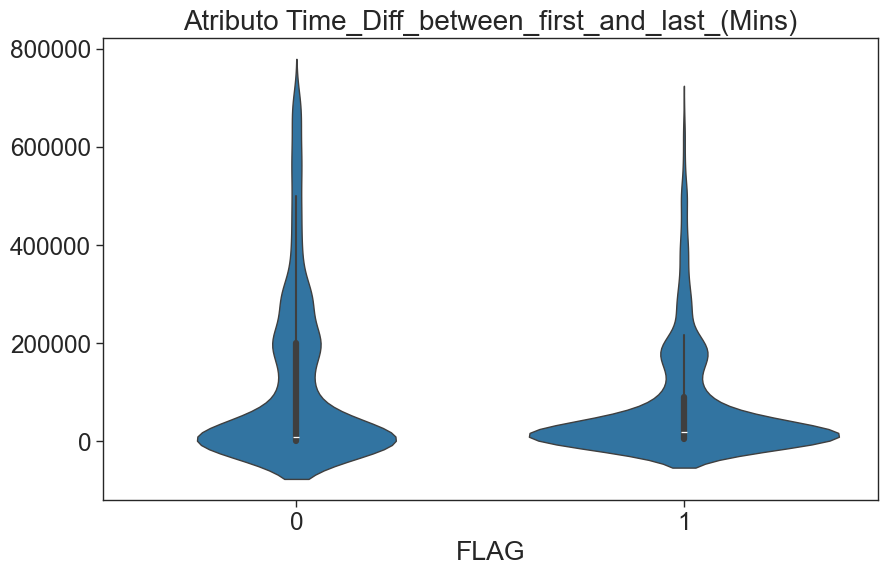

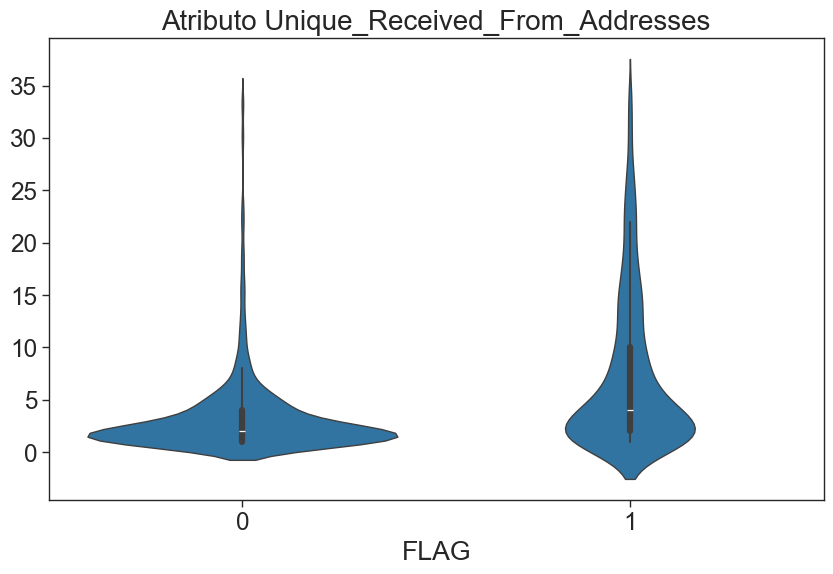

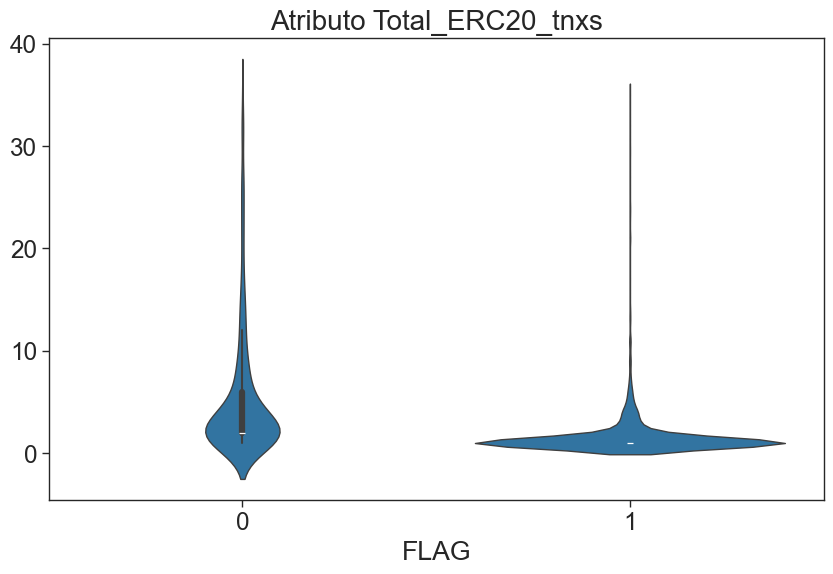

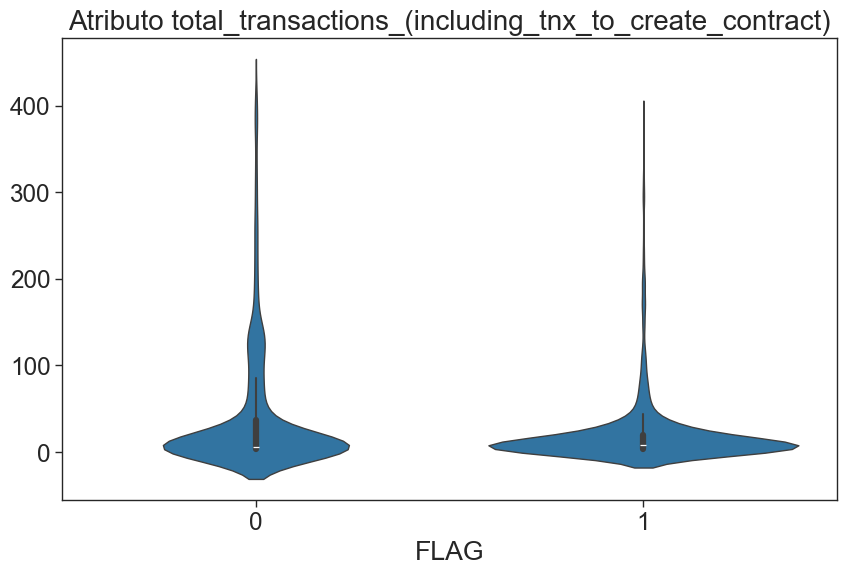

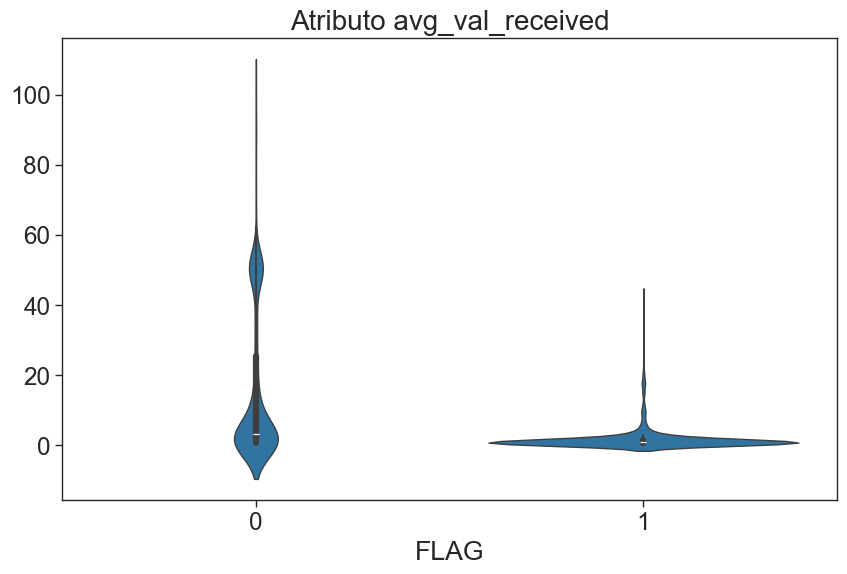

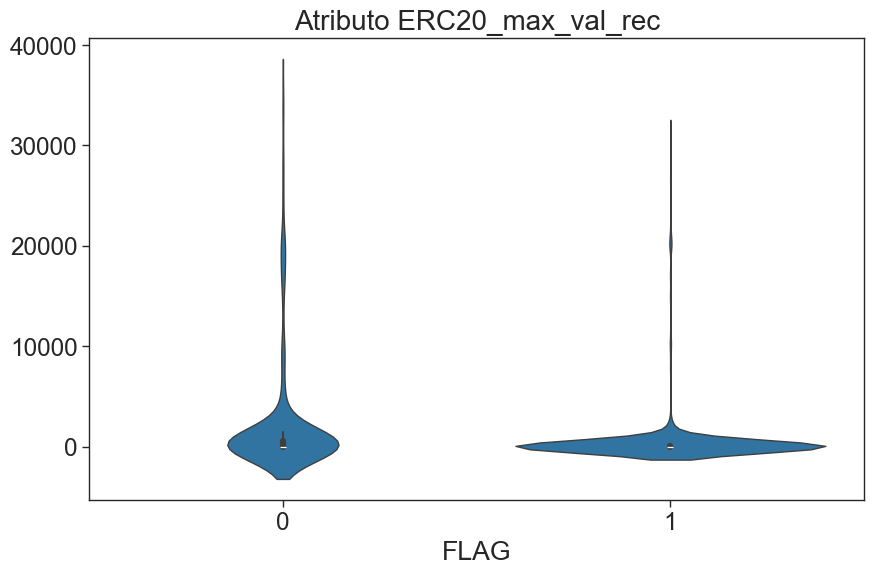

In [ ]:
for column in lst_most_important_features: 
    max_lim = np.percentile(df_important_features[column], 95)
    min_lim = np.percentile(df_important_features[column], 5)

    plt.figure(figsize=(10, 6))
    # plt.ylim(-100, 550000)

    ax = sns.violinplot(data=df_important_features.loc[
        (df_important_features[column] < max_lim) &
        (df_important_features[column] > min_lim)
    ], x='FLAG', y=column)
    ax.set_title(f"Atributo {column}", fontsize=20)
    ax.set_ylabel(None)


    plt.show();

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




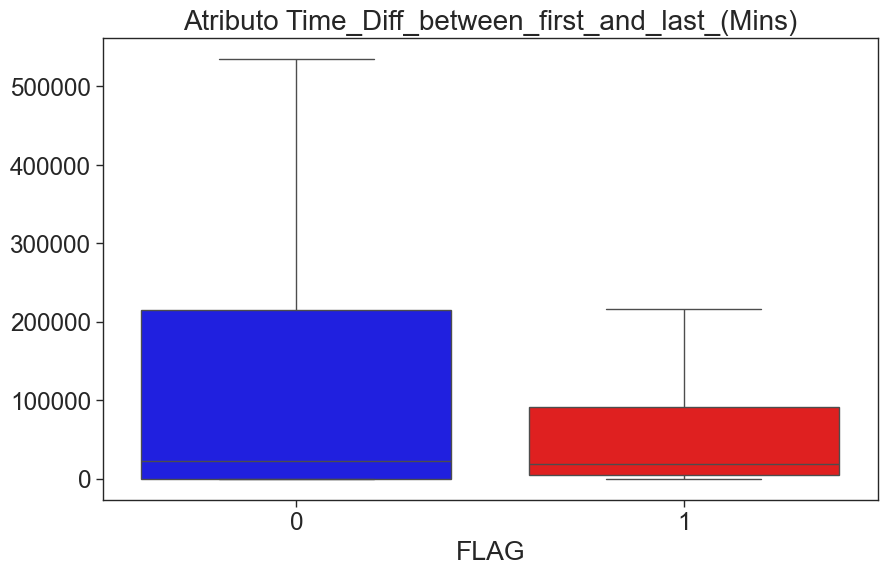

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




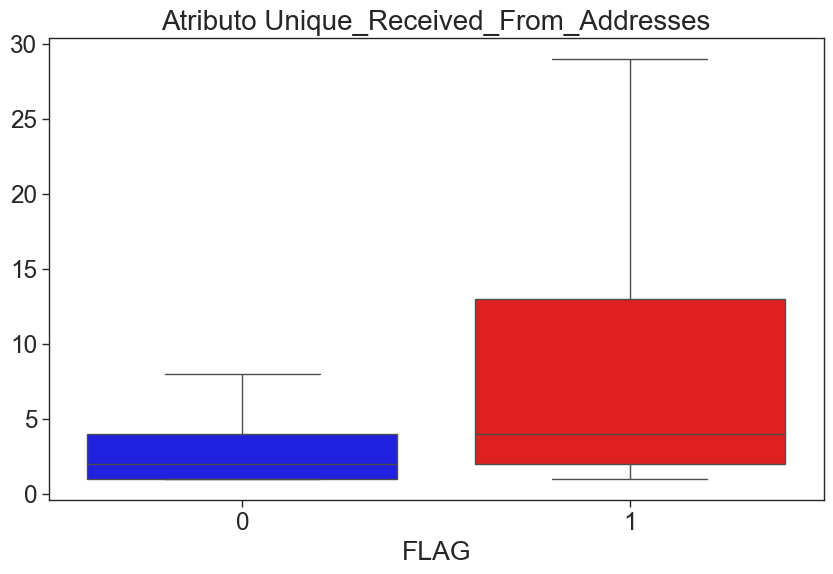

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




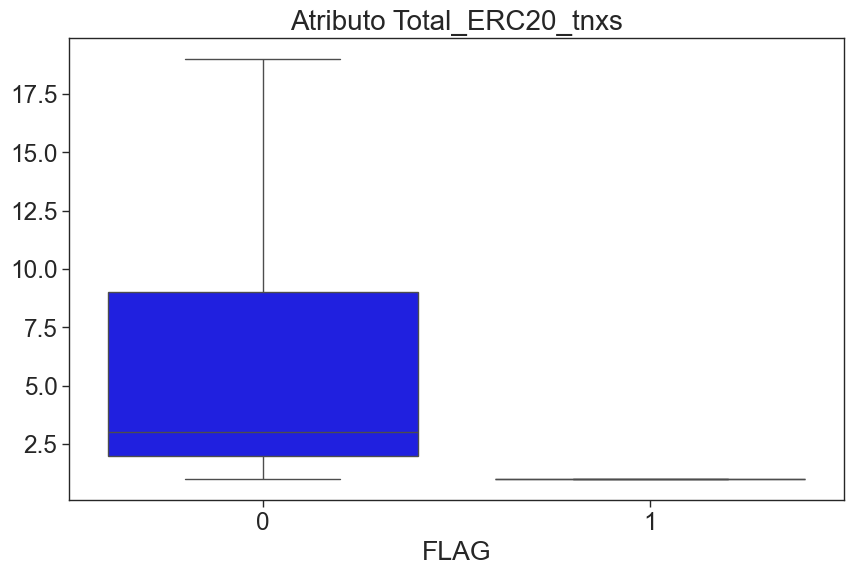

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




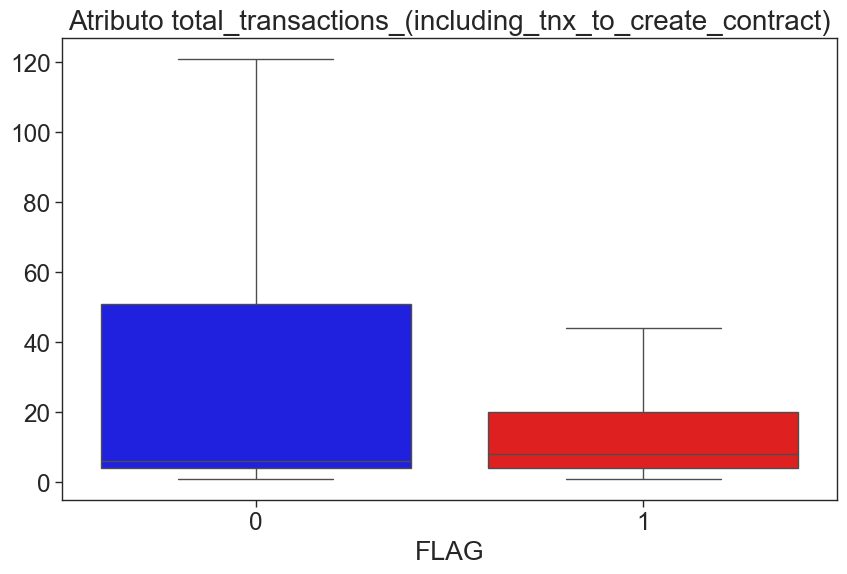

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




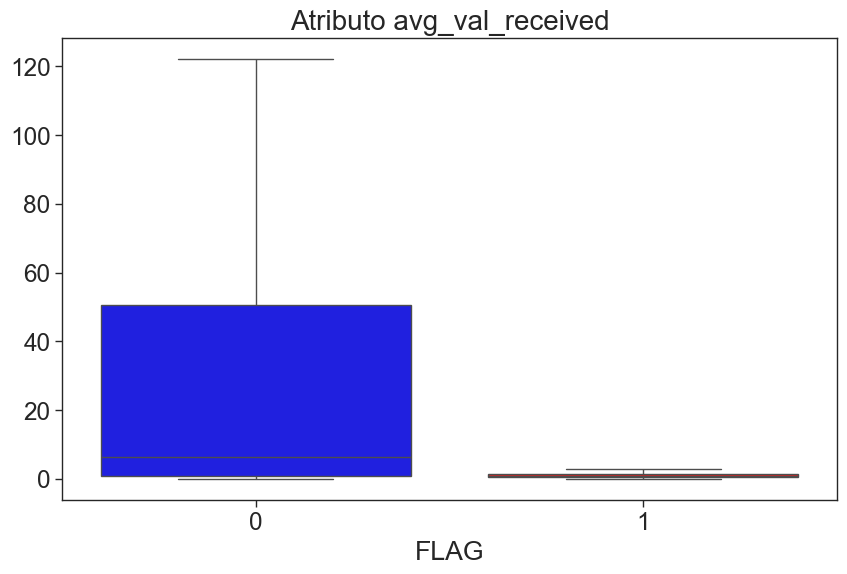

C:\Users\gusta\AppData\Local\Temp\ipykernel_28248\1045267276.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




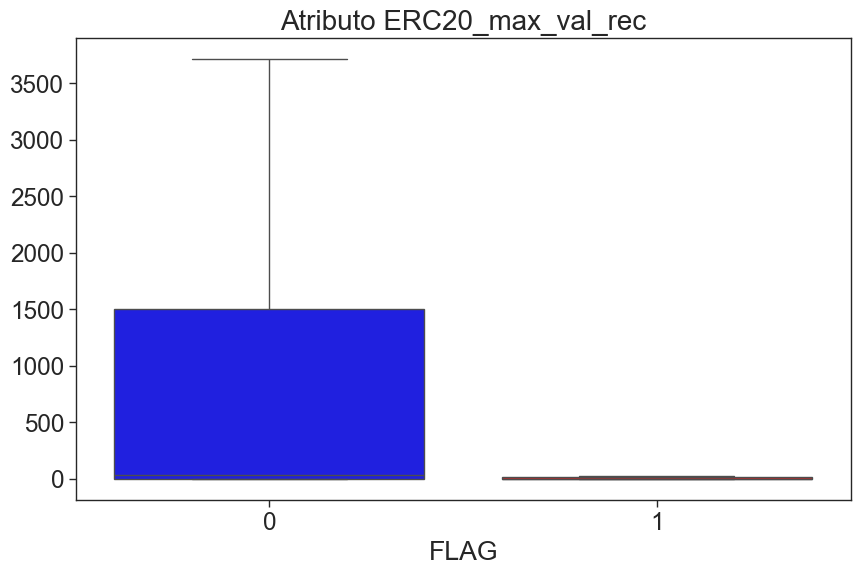

In [ ]:
for column in lst_most_important_features: 
    max_lim = np.percentile(df_important_features[column], 97.5)
    min_lim = np.percentile(df_important_features[column], 2.5)

    plt.figure(figsize=(10, 6))
    # plt.ylim(-100, 550000)

    ax = sns.boxplot(data=df_important_features.loc[
        (df_important_features[column] < max_lim) &
        (df_important_features[column] > min_lim)
    ], x='FLAG', y=column, palette=['b', 'r'], showfliers = False)
    ax.set_title(f"Atributo {column}", fontsize=20)
    ax.set_ylabel(None)


    plt.show();

In [ ]:
df_important_features.to_excel('../data/processed/Comparação para cada feature mais importante.xlsx', index=False)

### Split importance

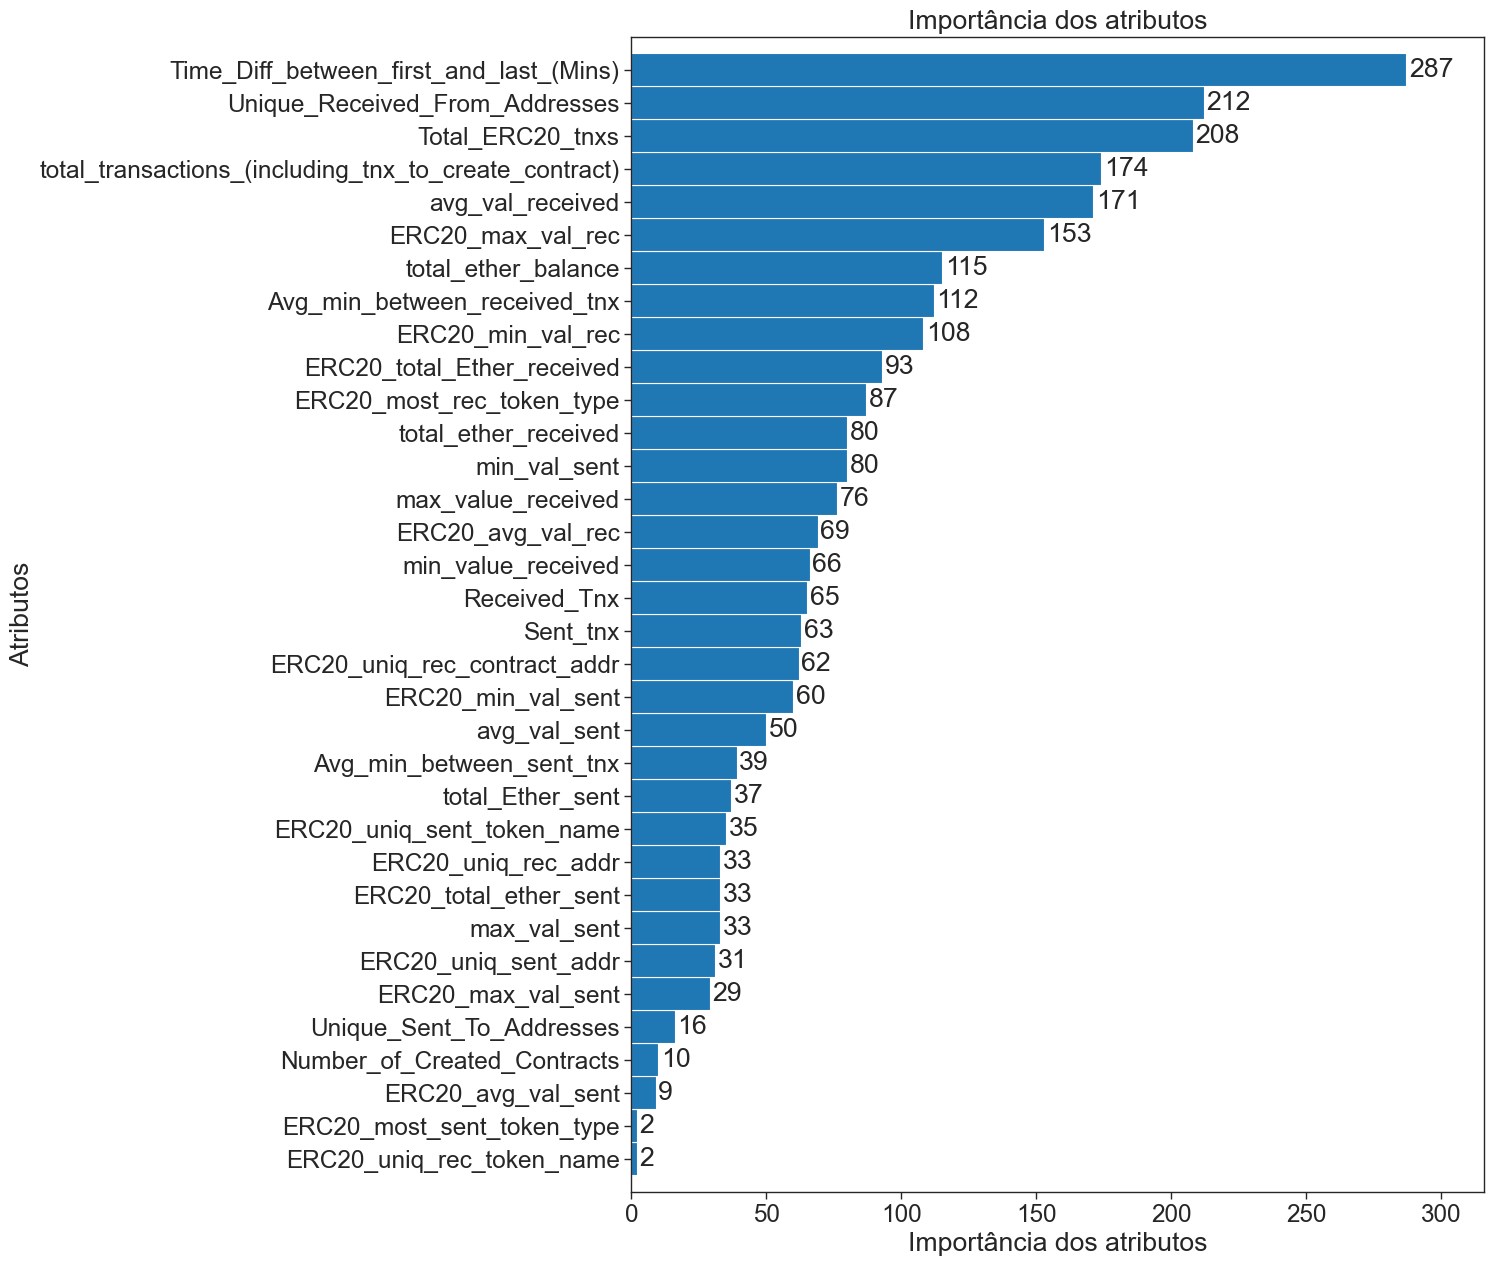

In [ ]:
plot_importance(
    classifier_lgbm_split, height=1, xlim=None, ylim=None,
    title='Importância dos atributos', xlabel='Importância dos atributos', ylabel='Atributos', importance_type='split',
    max_num_features=None, ignore_zero=True, figsize=(11, 15), dpi=None, grid=False, precision=0
);